# 机器学习：实践作业二

**王海生 10235101559**

In [1]:
# 环境配置

# 若在非 ModelArts 平台上，需要通过 wheel 文件手动安装 MindSpore 2.2
%pip install /Users/wanghaisheng/Downloads/mindspore-2.2.14-cp39-cp39-macosx_11_0_arm64.whl

%pip install numpy matplotlib

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
Processing /Users/wanghaisheng/Downloads/mindspore-2.2.14-cp39-cp39-macosx_11_0_arm64.whl
mindspore is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 导入MindSpore模块和辅助模块

import mindspore.nn as nn
from mindspore import Tensor
from mindspore import value_and_grad
import mindspore.dataset as ds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# 设置超参数（数据生成）

NUM_SAMPLES = 100       # 样本数量
BATCH_SIZE = 1          # 批量大小

In [4]:
# 生成数据

# 样本数量
num_samples = NUM_SAMPLES

# x范围从-1到1
x = np.linspace(-1, 1, num_samples).reshape(-1, 1).astype(np.float32)
true_y = -5 * x + 0.1

# 加入均值为0、标准差为1的噪声
noise = np.random.normal(0, 1, x.shape).astype(np.float32)
y = true_y + noise

# 定义数据生成器
def data_generator():
    for i in range(num_samples):
        yield x[i:i+1], y[i:i+1]  # 每次yield一个样本

# 使用GeneratorDataset创建数据集
dataset = ds.GeneratorDataset(source=data_generator, column_names=['data', 'label'])
dataset = dataset.batch(batch_size=BATCH_SIZE)

In [5]:
# 设置超参数（模型训练）

EPOCHS = 20             # 训练轮数
LEARNING_RATE = 0.01    # 学习率

In [6]:
# 模型构建

# 定义线性模型
class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc = nn.Dense(1, 1)  # 输入维度1，输出维度1，随机初始化权重w和偏置b
    
    def construct(self, x):
        return self.fc(x)  # 前向传播

# 实例化模型
net = LinearNet()

# 使用均方差作为损失函数
loss_fn = nn.MSELoss()

# 定义随机梯度下降优化器
optimizer = nn.SGD(net.trainable_params(), learning_rate=LEARNING_RATE)

# 定义前向计算函数
def forward_fn(data, label):
    output = net(data)  # 模型预测
    loss = loss_fn(output, label)  # 计算MSE损失
    return loss

# 使用value_and_grad接口获取微分函数
grad_fn = value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

# 定义train_step函数
def train_step(data, label):
    loss, grads = grad_fn(data, label)  # 计算损失和梯度
    optimizer(grads)  # 使用梯度更新参数
    return loss

Epoch 1/20, Average Loss: 4.4936
Epoch 2/20, Average Loss: 2.4502
Epoch 3/20, Average Loss: 1.4669
Epoch 4/20, Average Loss: 1.1853
Epoch 5/20, Average Loss: 1.1227
Epoch 6/20, Average Loss: 1.1136
Epoch 7/20, Average Loss: 1.1148
Epoch 8/20, Average Loss: 1.1170
Epoch 9/20, Average Loss: 1.1186
Epoch 10/20, Average Loss: 1.1194
Epoch 11/20, Average Loss: 1.1199
Epoch 12/20, Average Loss: 1.1202
Epoch 13/20, Average Loss: 1.1203
Epoch 14/20, Average Loss: 1.1203
Epoch 15/20, Average Loss: 1.1204
Epoch 16/20, Average Loss: 1.1204
Epoch 17/20, Average Loss: 1.1204
Epoch 18/20, Average Loss: 1.1204
Epoch 19/20, Average Loss: 1.1204
Epoch 20/20, Average Loss: 1.1204


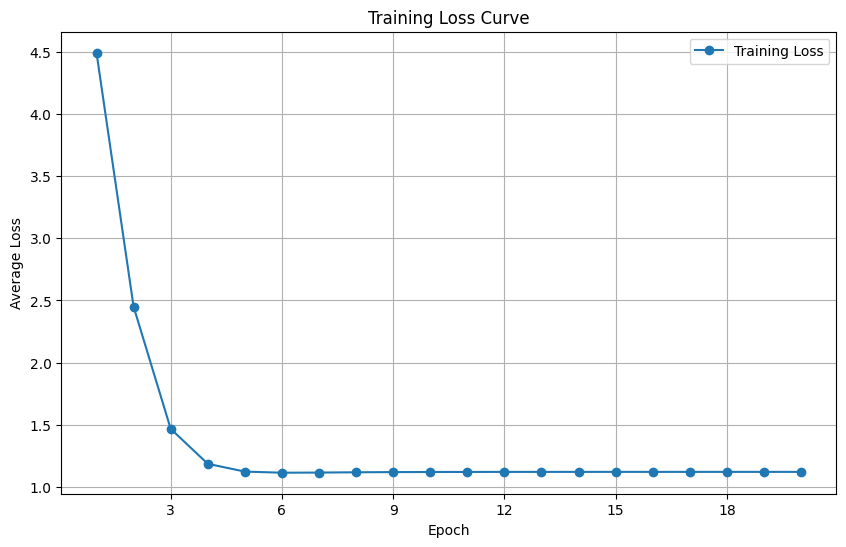

In [7]:
# 模型训练

epochs = EPOCHS
loss_history = []
for epoch in range(epochs):
    epoch_loss = 0
    for data, label in dataset.create_tuple_iterator():
        data = Tensor(data)  # 确保数据为Tensor
        label = Tensor(label)
        loss = train_step(data, label)  # 执行一步训练
        epoch_loss += loss.asnumpy()  # 累加损失
    avg_loss = epoch_loss / num_samples
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss:.4f}")

# 绘制 Loss 曲线
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, marker='o', linestyle='-', label='Training Loss')
plt.title("Training Loss Curve")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# 模型预测

# 查看参数的名称、维度、数据类型、数值以及是否求导
params = net.trainable_params()
print("模型参数列表：")
print(params)
for i, param in enumerate(params):
    print(f"\n第{i+1}个参数：")
    print(f"参数名称: {param.name}, 维度: {param.shape}, 数据类型: {param.dtype}, 数值: {param.asnumpy()}, 是否求导: {param.requires_grad}")

# 查看第一个可训练参数
first_param = params[0]
print(f"\n第一个可训练参数：\n{first_param}")

# 将第一个参数数组化
w_value = first_param.asnumpy()
print(f"\n第一个可训练参数（数组化）：\n{w_value}")

# 使用训练好的模型进行预测
x_tensor = Tensor(x)  # 将x转换为Tensor
pred_y = net(x_tensor).asnumpy()  # 预测值
print(f"\n预测值（前5个）：\n{pred_y[:5]}")

模型参数列表：
[Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True), Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True)]

第1个参数：
参数名称: fc.weight, 维度: (1, 1), 数据类型: Float32, 数值: [[-5.318723]], 是否求导: True

第2个参数：
参数名称: fc.bias, 维度: (1,), 数据类型: Float32, 数值: [0.16057935], 是否求导: True

第一个可训练参数：
Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True)

第一个可训练参数（数组化）：
[[-5.318723]]

预测值（前5个）：
[[5.4793024]
 [5.3718534]
 [5.264405 ]
 [5.1569557]
 [5.0495067]]


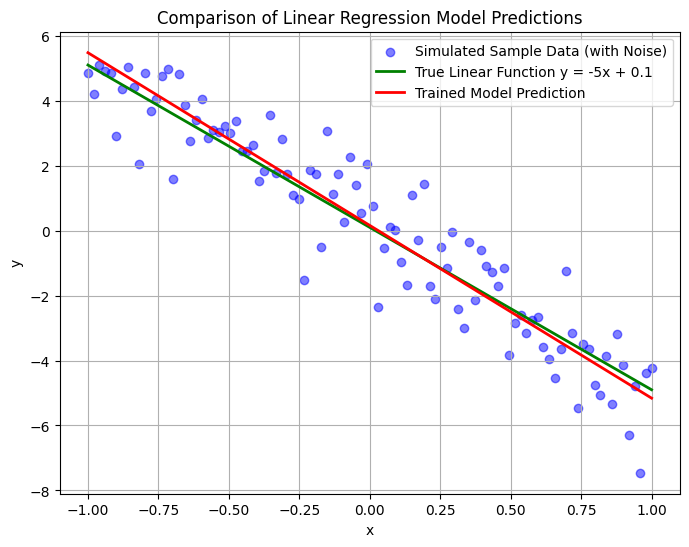

In [9]:
# 可视化

# 使用matplotlib绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Simulated Sample Data (with Noise)', color='blue', alpha=0.5)  # 模拟的样本数据
plt.plot(x, true_y, label='True Linear Function y = -5x + 0.1', color='green', linewidth=2)  # 真实的线性函数
plt.plot(x, pred_y, label='Trained Model Prediction', color='red', linewidth=2)  # 训练得到的线性模型
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Linear Regression Model Predictions')
plt.legend()
plt.grid(True)
plt.show()